# Спринт 14 «Численные методы»

# Проект «Определение стоимости автомобилей»

## Навигация

1. [Описание проекта](#Описание-проекта)
1. [Описание данных](#Описание-данных)
1. [Подготовка данных](#Подготовка-данных)
1. [Обучение моделей](#Обучение-моделей)
   - [CatBoost](#CatBoost)
   - [LightGBM](#LightGBM)
   - [RandomForest](#RandomForest)
1. [Анализ моделей](#Анализ-моделей)
1. [Общий вывод](#Общий-вывод)

## Описание проекта

[к навигации](#Навигация)

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Описание данных

[к навигации](#Навигация)

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [1]:
import os

import catboost
import lightgbm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split

In [2]:
RANDOM_STATE = 42

## Подготовка данных

[к навигации](#Навигация)

In [3]:
data = pd.read_csv(
    os.path.join('..', 'datasets', 'autos.csv'),
    usecols=[
        # 'DateCrawled',  # неинформативный признак
        'Price',
        'VehicleType',
        'RegistrationYear',
        'Gearbox',
        'Power',
        'Model',
        'Kilometer',
        'RegistrationMonth',
        'FuelType',
        'Brand',
        'Repaired',
        # 'DateCreated',  # неинформативный признак
        # 'NumberOfPictures',  # неинформативный признак (везде 0)
        # 'PostalCode',  # неинформативный признак
        'LastSeen',
    ],
)

data = data.rename(columns={
    'Price': 'price',
    'VehicleType': 'vehicle_type',
    'RegistrationYear': 'registration_year',
    'Gearbox': 'gearbox',
    'Power': 'power',
    'Model': 'model',
    'Kilometer': 'kilometer',
    'RegistrationMonth': 'registration_month',
    'FuelType': 'fuel_type',
    'Brand': 'brand',
    'Repaired': 'repaired',
    'LastSeen': 'last_seen',
})

CAT_FEATURES = [
    'vehicle_type',
    'gearbox',
    'model',
    'registration_month',
    'fuel_type',
    'brand',
    'repaired',
]
# заполняю пропуски у категориальных признаков
data[CAT_FEATURES] = data[CAT_FEATURES].fillna('miss').astype('category')

# аномальные значения меняю на пропуски
data.loc[(data['power'] < 60) | (data['power'] > 250), 'power'] = np.NaN

data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,last_seen
0,480,miss,1993,manual,NaN,golf,150000,0,petrol,volkswagen,miss,2016-04-07 03:16:57
1,18300,coupe,2011,manual,190.0,miss,125000,5,gasoline,audi,yes,2016-04-07 01:46:50
2,9800,suv,2004,auto,163.0,grand,125000,8,gasoline,jeep,miss,2016-04-05 12:47:46
3,1500,small,2001,manual,75.0,golf,150000,6,petrol,volkswagen,no,2016-03-17 17:40:17
4,3600,small,2008,manual,69.0,fabia,90000,7,gasoline,skoda,no,2016-04-06 10:17:21


In [4]:
pd.to_datetime(data['last_seen']).dt.year.unique()

array([2016], dtype=int64)

In [5]:
def foo(x):
    result = None
    oldest_car = 1885
    last_seen = 2016
    
    if oldest_car < x < last_seen:
        result = x
    else:
        result = np.NaN
        
    return result

In [6]:
data['registration_year'] = data['registration_year'].astype('float').apply(foo)

In [7]:
data = data.drop(columns='last_seen')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               354369 non-null  int64   
 1   vehicle_type        354369 non-null  category
 2   registration_year   330174 non-null  float64 
 3   gearbox             354369 non-null  category
 4   power               283133 non-null  float64 
 5   model               354369 non-null  category
 6   kilometer           354369 non-null  int64   
 7   registration_month  354369 non-null  category
 8   fuel_type           354369 non-null  category
 9   brand               354369 non-null  category
 10  repaired            354369 non-null  category
dtypes: category(7), float64(2), int64(2)
memory usage: 13.5 MB


In [9]:
data = data.query('price > 0')

---

In [10]:
sorted(data['registration_month'].unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

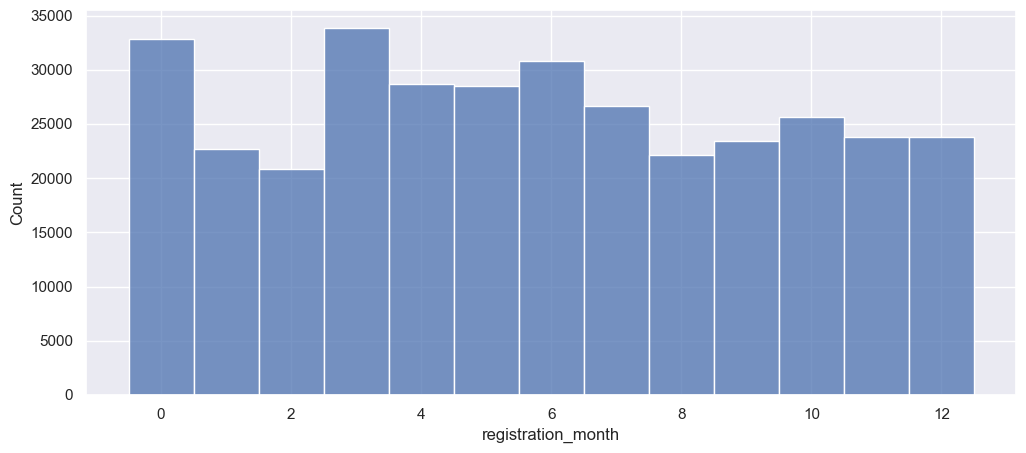

In [11]:
fig, ax = plt.subplots(figsize=(12, 5))

sns.histplot(
    data,
    x='registration_month',
    ax=ax,
);

In [12]:
data = data.drop(columns='registration_month')
CAT_FEATURES.remove('registration_month')

---

In [13]:
X = data.drop(columns='price')
y = data['price']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

## Обучение моделей

[к навигации](#Навигация)

### CatBoost

[к навигации](#Навигация)

In [15]:
gs_catboost = GridSearchCV(
    estimator=catboost.CatBoostRegressor(cat_features=CAT_FEATURES, verbose=0, random_state=RANDOM_STATE),
    param_grid={
        'learning_rate': [0.4, 0.5, 0.6],
        'n_estimators': [120, 130, 140, 150],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)

In [16]:
%%time
gs_catboost.fit(X_train, y_train)

CPU times: total: 38.5 s
Wall time: 8min 5s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x00000175642D34C0>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'n_estimators': [120, 130, 140, 150]},
             scoring='neg_mean_squared_error')

In [17]:
print('Лучшие гиперпараметры:')
for param, value in gs_catboost.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
learning_rate: 0.5
n_estimators: 150


### LightGBM

[к навигации](#Навигация)

In [18]:
gs_lgbm = GridSearchCV(
    estimator=lightgbm.LGBMRegressor(random_state=RANDOM_STATE),
    param_grid={
        'learning_rate': [0.4, 0.5, 0.6],
        'n_estimators': [170, 180, 190, 200],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)

In [19]:
%%time
gs_lgbm.fit(X_train, y_train)

CPU times: total: 5.33 s
Wall time: 59.4 s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.4, 0.5, 0.6],
                         'n_estimators': [170, 180, 190, 200]},
             scoring='neg_mean_squared_error')

In [20]:
print('Лучшие гиперпараметры:')
for param, value in gs_lgbm.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
learning_rate: 0.4
n_estimators: 200


### RandomForest

[к навигации](#Навигация)

In [21]:
gs_rf = GridSearchCV(
    estimator=lightgbm.LGBMRegressor(
        boosting_type='rf',
        bagging_fraction=0.75,
        random_state=RANDOM_STATE,
        bagging_freq=2,
    ),
    param_grid={
        'n_estimators': np.linspace(10, 150, num=5, dtype='int'),
        'max_depth': [5, 6, 7, 8, 9, 10],
    },
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE),
)

In [22]:
%%time
gs_rf.fit(X_train, y_train)

CPU times: total: 8.94 s
Wall time: 2min 24s


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=42, test_size=0.25, train_size=None),
             estimator=LGBMRegressor(bagging_fraction=0.75, bagging_freq=2,
                                     boosting_type='rf', random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 6, 7, 8, 9, 10],
                         'n_estimators': array([ 10,  45,  80, 115, 150])},
             scoring='neg_mean_squared_error')

In [23]:
print('Лучшие гиперпараметры:')
for param, value in gs_rf.best_params_.items():
    print(f'{param}: {value}')

Лучшие гиперпараметры:
max_depth: 9
n_estimators: 115


## Анализ моделей

[к навигации](#Навигация)

In [24]:
def report(gscv):
    fit_time = gscv.cv_results_['mean_fit_time'].mean()
    score_time = gscv.cv_results_['mean_score_time'].mean()
    RMSE = (-gscv.cv_results_['mean_test_score'].mean()) ** 0.5

    print(f'Время обучения: {fit_time:.2f}, время предсказания: {score_time:.2f} и качество модели: {RMSE:.2f}\n')

In [25]:
for name, gscv in zip(['CatBoost', 'LightGBM', 'RandomForest'], [gs_catboost, gs_lgbm, gs_rf]):
    print(name)
    report(gscv)

CatBoost
Время обучения: 30.49, время предсказания: 0.10 и качество модели: 1760.18

LightGBM
Время обучения: 2.90, время предсказания: 0.76 и качество модели: 1691.86

RandomForest
Время обучения: 3.29, время предсказания: 0.36 и качество модели: 2384.17



In [26]:
lgbm_model = gs_lgbm.best_estimator_
y_pred = lgbm_model.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred) ** 0.5
RMSE

1653.8381140467395

## Общий вывод

[к навигации](#Навигация)

| Модель       | Время обучения, сек | Время предсказания, сек | Качество модели, RMSE |
|--------------|---------------------|-------------------------|-----------------------|
| CatBoost     | 30.49               | 0.10                    | 1760.18               |
| LightGBM     | 2.90                | 0.76                    | 1691.86               |
| RandomForest | 3.29                | 0.36                    | 2384.17               |